In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import geojson
from shapely.ops import split
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd
from numpy import ones,vstack
from numpy.linalg import lstsq
import pandas as pd
import csv
import openpyxl
from itertools import islice
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy

In [2]:
input_file = '/tmp/Inputs/SLD_0000540.vsi - 20x_01 Detections.txt'
wb = openpyxl.Workbook()
ws = wb.worksheets[0]

with open(input_file, 'r') as data:
    reader = csv.reader(data, delimiter='\t')
    for row in reader:
        ws.append(row) 
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df_404 = pd.DataFrame(data, index=idx, columns=cols)
cells_centroid_x = df_404['Centroid X µm'].to_numpy(dtype=float)
cells_centroid_y = df_404['Centroid Y µm'].to_numpy(dtype=float)

In [3]:
pixel_size = 0.346
annotations_geo = geojson.load(open('/tmp/Inputs/SLD_0000540.vsi - 20x_01_annotations.json','rb'))

In [4]:
annotations = {}
for entry in annotations_geo:
    try:
        ## 'bottom_left', 'bottom_right', 'top_left', 'top_right' annotations
        if "name" in entry["properties"].keys():
            annotations[entry["properties"]["name"]] = \
                np.array(entry["geometry"]["coordinates"])
        ## S1 annotation has a classification key b4 name
        if "classification" in entry["properties"].keys():
            if "name" in entry["properties"]["classification"].keys():
                if entry["properties"]["classification"]["name"] != "SliceContour" and\
                        entry["properties"]["classification"]["name"] != 'Other':
                    annotations[entry["properties"]["classification"]["name"]] = np.array(entry["geometry"]["coordinates"])
    except KeyError:  # annotation without name
        pass

In [5]:
annotations

{'top_right': array([19773.36,  2506.45]),
 'top_left': array([15776.22,  4196.74]),
 'bottom_left': array([17795.06,  9793.66]),
 'bottom_right': array([20728.83,  7397.25]),
 'S1': array([[[19773.4 ,  2506.42],
         [19764.  ,  2513.  ],
         [19758.  ,  2515.18],
         ...,
         [19774.  ,  2509.  ],
         [19774.  ,  2508.51],
         [19773.4 ,  2506.42]]])}

In [6]:

s1_coordinates = annotations['S1'][0] * pixel_size

# These 4 points can not be find via an algo, so we need QuPath annotation
top_left = annotations['top_left'] * pixel_size
bottom_left = annotations['bottom_left'] * pixel_size
top_right = annotations['top_right'] * pixel_size
bottom_right = annotations['bottom_right'] * pixel_size
quadrilateral = np.array([top_left, top_right, bottom_right, bottom_left, top_left])

nb_row = 100
nb_col = 100

In [7]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [8]:
def getExtrapoledLine(line_string, EXTRAPOL_RATIO=1.5):
    'Creates a line extrapoled in both directions'
    p1=np.array(line_string)[0] 
    p2=np.array(line_string)[1]
    a = (p2[0]+EXTRAPOL_RATIO*(p1[0]-p2[0]), p2[1]+EXTRAPOL_RATIO*(p1[1]-p2[1])) 
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]))
    return LineString([a,b])

In [23]:
def create_grid(quadrilateral, s1_coordinates, nb_row, nb_col):
    """
    Args:
        qudrilateral(np.array): shape(5, 2). top_left, top_right, bottom_right, bottom_left, top_left
    """
    top_left = quadrilateral[0]
    top_right = quadrilateral[1]
    bottom_right = quadrilateral[2]
    bottom_left = quadrilateral[3]
    
    # Vertical lines
    lines = [LineString([[top_left[0]-100, top_left[1]], [bottom_left[0]-100, bottom_left[1]]])]
    for i in range(nb_col-1):
        top_point = top_left + (top_right - top_left) / nb_col * (i+1)
        bottom_point = bottom_left + (bottom_right - bottom_left) / nb_col * (i+1)
        line = LineString([(top_point[0], top_point[1]), (bottom_point[0], bottom_point[1])])
        line = getExtrapoledLine(line, 1.3)
        try:
            intersection_line = Polygon(s1_coordinates).intersection(line).coords
            lines.append(intersection_line)
        except NotImplementedError:
        #    intersection_line = list(Polygon(quadrilateral).intersection(line).coords)
            pass
    lines.append(LineString([[top_right[0]+100, top_right[1]], [bottom_right[0]+100,bottom_right[1]]]))
              
    # Horizontal lines
    horizontal_lines = []  
    for i in range(nb_row-1):
        horizontal_points = []
        for index, line in enumerate(lines) : 
            line_coord = np.array(line)
            point = line_coord[0] + (line_coord[1] - line_coord[0]) / nb_row * (i+1)
            horizontal_points.append(point)
        horizontal_line = LineString(horizontal_points)
        horizontal_lines.append(horizontal_line)
        
    '''
    left_extended = []
    for horizontal_line in horizontal_lines:
        print(np.array(horizontal_line)[0])
        print(np.array(horizontal_line)[1])
        line_coord = np.array(horizontal_line)
        left_horizontal_line=getExtrapoledLine(LineString([(line_coord[0][0], line_coord[0][1]),
                                                           (line_coord[1][0], line_coord[1][1])]),
                                               'both' , 2.0)
        left_extended.append(left_horizontal_line)
                                                           
        break
    '''
    return lines, horizontal_lines
    
    

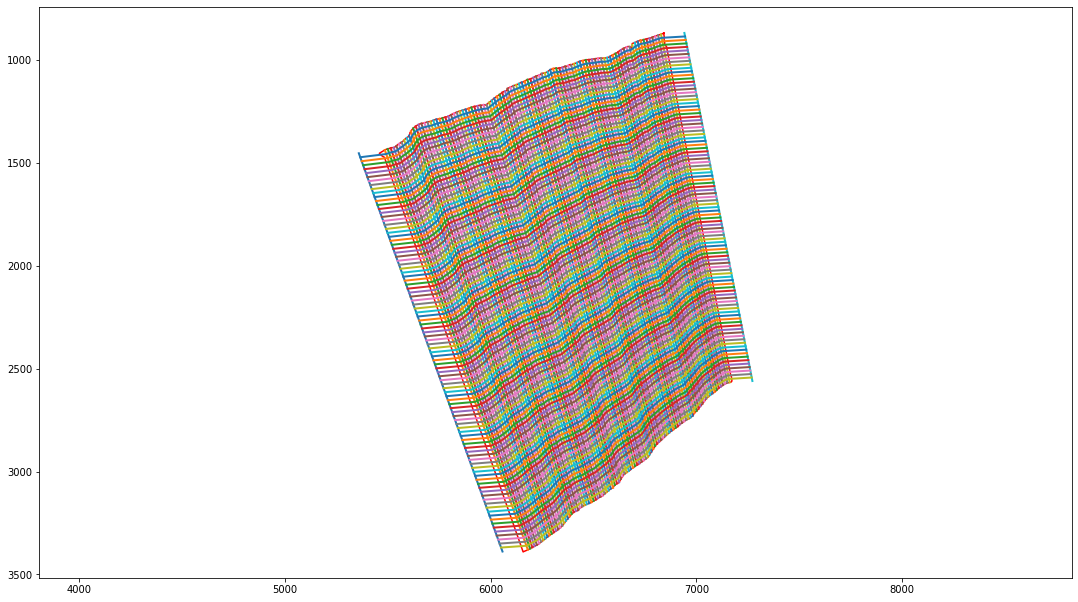

In [24]:

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')
vertical_lines, horizontal_lines = create_grid(quadrilateral, s1_coordinates, nb_row, nb_col)
for line in vertical_lines:
    line_coord = np.array(line)
    plt.plot(line_coord[:,0], line_coord[:,1], linewidth=2)
             

for line in horizontal_lines:
    line_coord = np.array(line)
    plt.plot(line_coord[:,0], line_coord[:,1], linewidth=2)
    


DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG index: 0
DEBUG inde

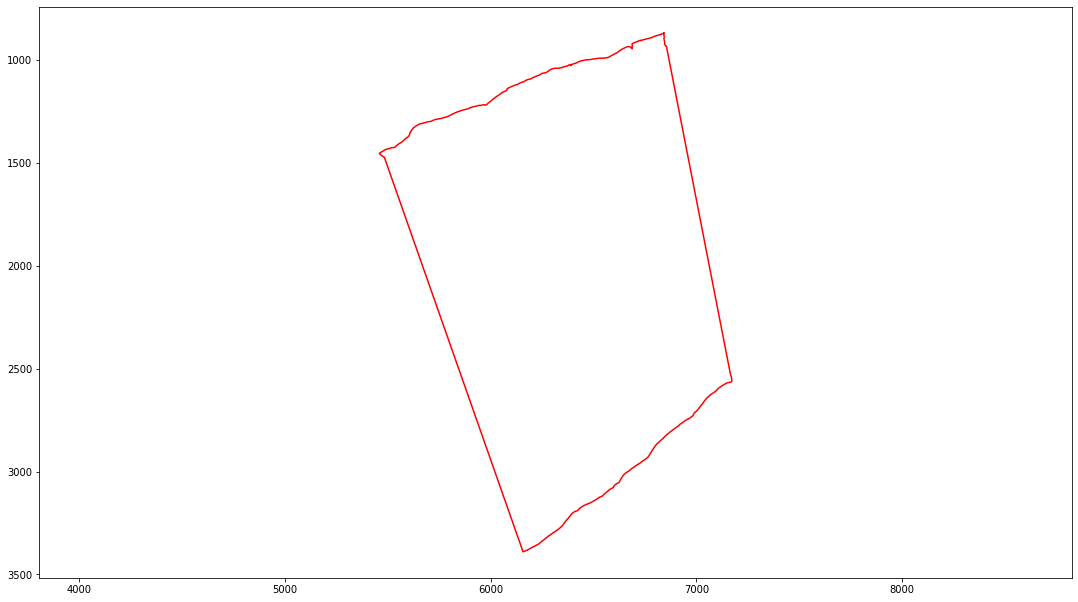

In [25]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')



split_polygons = []
polygon_to_split = Polygon(s1_coordinates)
index = 0
for line in horizontal_lines: 
    plot_line = np.array(line)
    print('DEBUG index:', index)
    #plt.plot(plot_line[:,0], plot_line[:,1])
    split_result = split(polygon_to_split, line)

    polygon_to_split = split_result[1]
    split_polygons.append(split_result[0])

    
split_polygons.append(polygon_to_split)

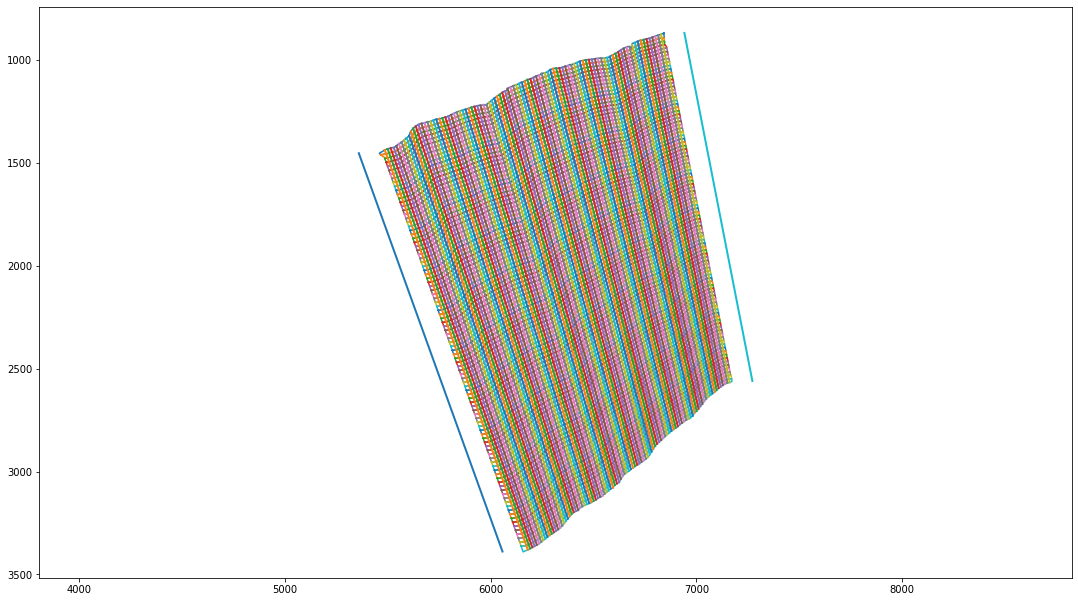

In [26]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
for polygon in split_polygons:
    x,y = polygon.exterior.xy
    plt.plot(x,y)
for line in vertical_lines:
    line_coord = np.array(line)
    plt.plot(line_coord[:,0], line_coord[:,1], linewidth=2)    

In [27]:
depthes = [-1] * len(cells_centroid_x)
for cell_index, (x, y) in enumerate(zip (cells_centroid_x, cells_centroid_y)):
    for index, polygon in enumerate(split_polygons):
        if polygon.contains(Point([x,y])):
            depthes[cell_index] = index
    

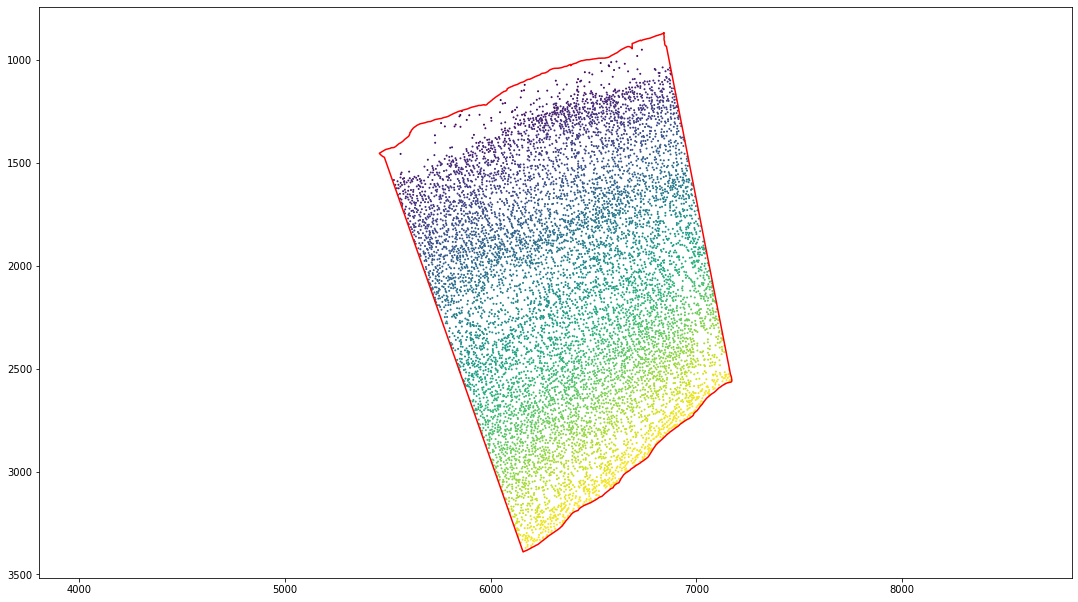

In [28]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')

plt.scatter(cells_centroid_x, cells_centroid_y, c=np.array(depthes), s=1)

# Compute densities as function of percentage of depth

In [29]:
nb_cell_per_slide = [0] * len(split_polygons)
for x, y in zip (cells_centroid_x, cells_centroid_y):
    for index, polygon in enumerate(split_polygons):
        if polygon.contains(Point([x,y])):
            nb_cell_per_slide[index]+=1

In [30]:
densities = []
z_length = 50 / 1e3 # mm
areas = []
for nb_cell, polygon in zip(nb_cell_per_slide, split_polygons):
    areas.append(polygon.area)
    densities.append(nb_cell/ ((polygon.area / 1e6) * z_length))

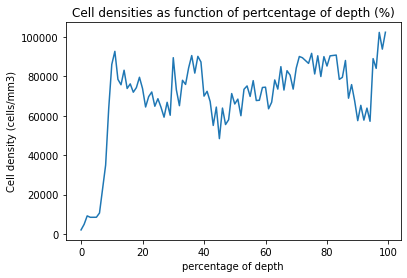

In [31]:
plt.plot([i/nb_row*100 for i in range(nb_row)], densities)
plt.xlabel("percentage of depth")
plt.ylabel("Cell density (cells/mm3)")
plt.title("Cell densities as function of pertcentage of depth (%)")
plt.show()

In [ ]:
from os import listdir
from os.path import isfile, join
mypath='/Users/jacquemi/working_dir/Molcular_systems/Rat_sscx_nissl/Inputs'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
image_names = []
for filename in onlyfiles:
    prefix_pos =  filename.find('_cell_position.txt')
    if prefix_pos != -1:
        image_name = filename[:prefix_pos]
        if image_name+'_annotations.geojson' in onlyfiles:
            image_names.append(image_name)
        else:
            print('ERROR: {} does not exist for image {}'.format( image_name+'_annotations.geojson' , image_name))
        

In [ ]:
image_names

In [ ]:
nb_cells = cells_centroid_x.shape[0]
nb_cells

In [ ]:
z_length = 50 / 1e3 # mm
total_volumes = Polygon(s1_coordinates).area / 1e6 * z_length
total_volumes

In [ ]:
nb_cells / total_volumes

## NEW Algo to create vertical lines

In [17]:
x_top_length = top_right[0] - top_left[0]
x_bot_length = bottom_right[0] - bottom_left[0]
x_top_step = x_top_length / nb_col
x_bot_step = x_bot_length / nb_col
print(x_top_step, x_bot_step)

13.8301044 10.150844200000002


In [22]:
lines = []
for row_id in range(nb_row):
    top_point = top_left[0] + (x_top_step * row_id)
    bot_point = bottom_left[0] + (x_bot_step * row_id)
    #print(top_point, bot_point)
    print(np.where(s1_coordinates[:,0] <= top_point))
    break

(array([], dtype=int64),)
